<a href="https://colab.research.google.com/github/Kajalsah1/2418104_kajalsah/blob/main/Worksheet_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Problem 1 – KNN Classification from Scratch (Diabetes Dataset)
1. Load Dataset & EDA

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/workshop4/diabetes.csv")

print("First 5 rows:")
print(data.head())

print("\nDataset Info:")
print(data.info())

print("\nSummary Statistics:")
print(data.describe())

print("\nMissing Values:")
print(data.isnull().sum())



First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   

2. Handle Missing Data

(For diabetes dataset, zero values in some columns indicate missing data.)

In [18]:
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in cols_with_zero:
    data[col] = data[col].replace(0, np.nan)
    data[col].fillna(data[col].mean(), inplace=True)

print("\nMissing values after handling:")
print(data.isnull().sum())



Missing values after handling:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-368317095.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


3. Feature Engineering & Train–Test Split (70–30)

In [19]:
# Feature matrix and target vector
X = data.drop(columns=["Outcome"]).values
y = data["Outcome"].values.astype(int)

def train_test_split_scratch(X, y, test_size=0.3, random_seed=42):
    np.random.seed(random_seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    test_size_n = int(len(X) * test_size)
    test_idx = indices[:test_size_n]
    train_idx = indices[test_size_n:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_scratch(X, y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)




X_train shape: (538, 8)
X_test shape: (230, 8)
y_train shape: (538,)
y_test shape: (230,)


4. KNN Implementation from Scratch
Euclidean Distance

In [20]:
def euclidean_distance(point1, point2):
    if point1.shape != point2.shape:
        raise ValueError("Points must have same dimensions")
    return np.sqrt(np.sum((point1 - point2) ** 2))


Predict Single Sample

In [21]:
def knn_predict_single(query, X_train, y_train, k=3):
    distances = [euclidean_distance(query, x) for x in X_train]
    sorted_indices = np.argsort(distances)
    nearest_indices = sorted_indices[:k]
    nearest_labels = y_train[nearest_indices]
    return np.bincount(nearest_labels).argmax()



Predict All Test Samples

In [22]:
def knn_predict(X_test, X_train, y_train, k=3):
    return np.array([knn_predict_single(x, X_train, y_train, k) for x in X_test])



 Accuracy Evaluation

In [23]:
def compute_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return (correct / len(y_true)) * 100
predictions = knn_predict(X_test, X_train, y_train, k=3)
acc_unscaled = compute_accuracy(y_test, predictions)

print(f"Accuracy (Unscaled Data): {acc_unscaled:.2f}%")



Accuracy (Unscaled Data): 70.00%


Problem 2: Scale features, rerun KNN, compare

In [24]:
def standardize_fit(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1
    return mean, std

def standardize_transform(X, mean, std):
    return (X - mean) / std

mean, std = standardize_fit(X_train)

X_train_scaled = standardize_transform(X_train, mean, std)
X_test_scaled = standardize_transform(X_test, mean, std)

pred_scaled = knn_predict(X_test_scaled, X_train_scaled, y_train, k=3)
acc_scaled = compute_accuracy(y_test, pred_scaled)

print(f"Accuracy (Scaled Data): {acc_scaled:.2f}%")
print(f"Comparison → Unscaled: {acc_unscaled:.2f}% | Scaled: {acc_scaled:.2f}%")



Accuracy (Scaled Data): 66.96%
Comparison → Unscaled: 70.00% | Scaled: 66.96%


Problem 3 – Experimentation with Different k Values

In [25]:
def experiment_knn_k_values(X_train, y_train, X_test, y_test, k_values):
    accuracies = []
    times = []

    for k in k_values:
        start = time.time()
        preds = knn_predict(X_test, X_train, y_train, k)
        elapsed = time.time() - start

        acc = compute_accuracy(y_test, preds)

        accuracies.append(acc)
        times.append(elapsed)

        print(f"k={k} | Accuracy={acc:.2f}% | Time={elapsed:.4f}s")

    return accuracies, times

k_values = list(range(1, 16))
print("Unscaled Data:")
acc_unscaled_k, time_unscaled = experiment_knn_k_values(
    X_train, y_train, X_test, y_test, k_values
)

print("\nScaled Data:")
acc_scaled_k, time_scaled = experiment_knn_k_values(
    X_train_scaled, y_train, X_test_scaled, y_test, k_values
)



Unscaled Data:
k=1 | Accuracy=67.83% | Time=0.8688s
k=2 | Accuracy=70.43% | Time=0.8636s
k=3 | Accuracy=70.00% | Time=0.8762s
k=4 | Accuracy=70.87% | Time=1.4097s
k=5 | Accuracy=67.39% | Time=1.6966s
k=6 | Accuracy=68.70% | Time=1.5993s
k=7 | Accuracy=68.26% | Time=0.9477s
k=8 | Accuracy=69.13% | Time=0.8840s
k=9 | Accuracy=69.13% | Time=0.8552s
k=10 | Accuracy=70.87% | Time=0.8745s
k=11 | Accuracy=70.87% | Time=0.8832s
k=12 | Accuracy=71.30% | Time=0.8710s
k=13 | Accuracy=71.30% | Time=0.8331s
k=14 | Accuracy=72.17% | Time=0.8665s
k=15 | Accuracy=73.48% | Time=0.8332s

Scaled Data:
k=1 | Accuracy=64.78% | Time=0.8460s
k=2 | Accuracy=68.70% | Time=0.8557s
k=3 | Accuracy=66.96% | Time=1.1170s
k=4 | Accuracy=70.87% | Time=1.4919s
k=5 | Accuracy=70.87% | Time=1.5775s
k=6 | Accuracy=69.57% | Time=1.0802s
k=7 | Accuracy=70.43% | Time=0.8679s
k=8 | Accuracy=71.74% | Time=0.8694s
k=9 | Accuracy=71.30% | Time=0.8772s
k=10 | Accuracy=72.61% | Time=0.8783s
k=11 | Accuracy=73.48% | Time=0.8591s
k

Visualizations

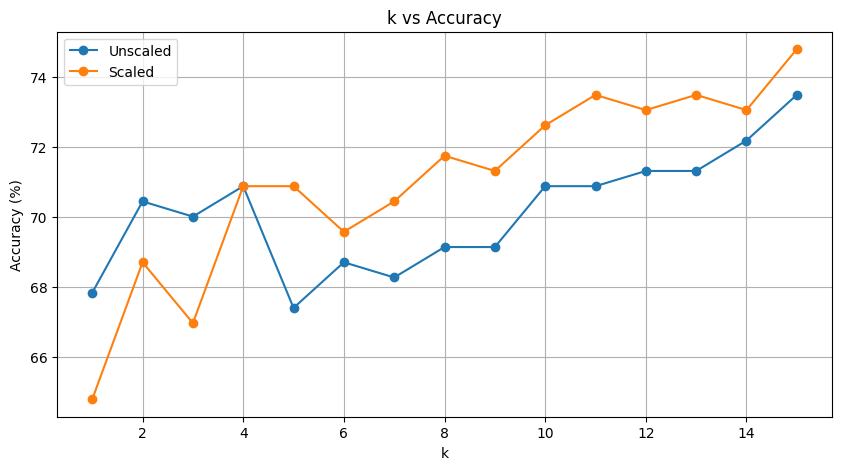

In [26]:
plt.figure(figsize=(10,5))
plt.plot(k_values, acc_unscaled_k, marker='o', label="Unscaled")
plt.plot(k_values, acc_scaled_k, marker='o', label="Scaled")
plt.xlabel("k")
plt.ylabel("Accuracy (%)")
plt.title("k vs Accuracy")
plt.legend()
plt.grid()
plt.show()


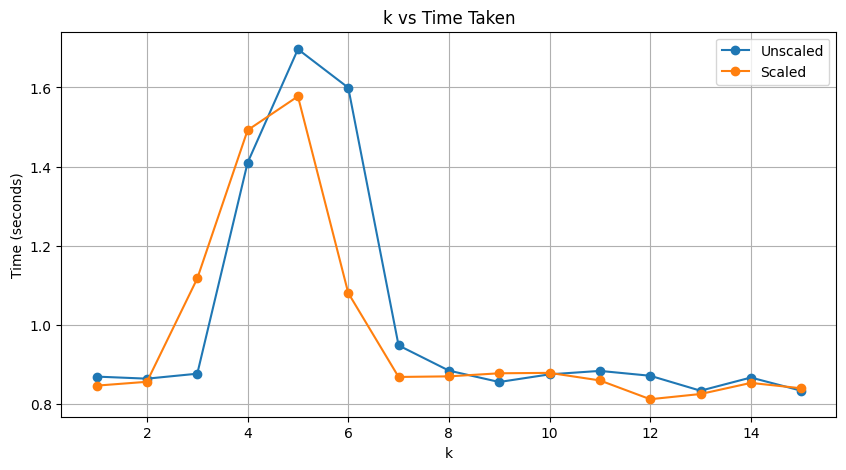

In [27]:
plt.figure(figsize=(10,5))
plt.plot(k_values, time_unscaled, marker='o', label="Unscaled")
plt.plot(k_values, time_scaled, marker='o', label="Scaled")
plt.xlabel("k")
plt.ylabel("Time (seconds)")
plt.title("k vs Time Taken")
plt.legend()
plt.grid()
plt.show()
